## HW Extra - Question 2

In [1]:
!pip install datasets
!pip install transformers
!pip install --upgrade accelerate
!pip install -U sentence-transformers
!pip install wandb
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=3325271016c242246b80053675da32eb005adfa0eaaabd0d9e8657197935bb2b
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 12.4

In [2]:
import pandas as pd
import numpy as np
import torch
import wandb
from transformers import AutoConfig, AutoTokenizer, AutoModel, Trainer, TrainingArguments, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from datasets import Dataset, load_metric
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import torch.nn as nn
from peft import LoraConfig, get_peft_model, TaskType, PeftModel

In [3]:
storage_options = {'User-Agent': 'Mozilla/5.0'}
df = pd.read_csv('http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv', storage_options=storage_options, sep='\t')
df.reset_index(drop=True, inplace=True)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.drop(['id', 'qid1', 'qid2'], axis=1 , inplace = True)
df.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   question1     404289 non-null  object
 1   question2     404288 non-null  object
 2   is_duplicate  404290 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.3+ MB


In [6]:
df.dropna(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   question1     404287 non-null  object
 1   question2     404287 non-null  object
 2   is_duplicate  404287 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 12.3+ MB


<Axes: title={'center': 'Classes Distribution in dataset'}>

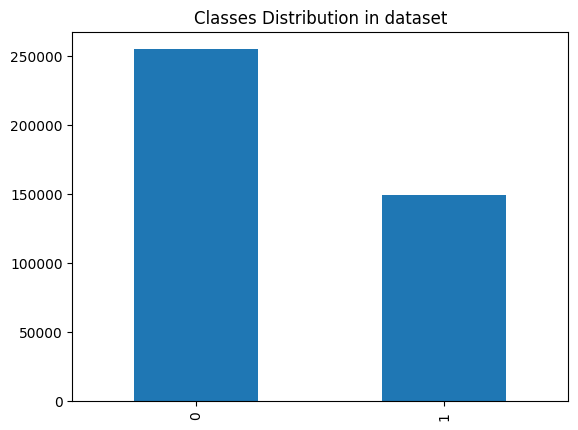

In [8]:
df['is_duplicate'].value_counts().plot(kind="bar",title='Classes Distribution in dataset')

In [9]:
df.groupby('is_duplicate').count()

,question1,question2
is_duplicate,,
0,255024,255024
1,149263,149263


In [10]:
count_0 = df[df['is_duplicate'] == 0].shape[0]
count_1 = df[df['is_duplicate'] == 1].shape[0]
imbalance = count_0 - count_1

sampled_indices = np.random.choice(df[df['is_duplicate'] == 0].index, size=imbalance, replace=False)
df = df.drop(sampled_indices)

<Axes: title={'center': 'Classes Distribution in dataset'}>

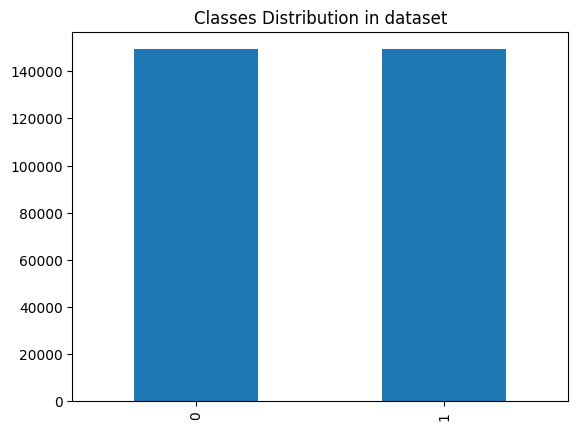

In [11]:
df['is_duplicate'].value_counts().plot(kind="bar",title='Classes Distribution in dataset')

In [ ]:
num_rows_to_keep = int(df.shape[0] * 0.01)
sampled_indices = np.random.choice(df.index, size=num_rows_to_keep, replace=False)
df = df.loc[sampled_indices]

In [ ]:
df.rename(columns={'is_duplicate': 'label'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2985 entries, 56828 to 226915
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   question1  2985 non-null   object
 1   question2  2985 non-null   object
 2   label      2985 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 93.3+ KB


In [ ]:
df['question1']= df['question1'].apply(lambda x: x.lower())
df['question2']= df['question2'].apply(lambda x: x.lower())

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-large", truncation=True, padding=True)
model = AutoModelForSequenceClassification.from_pretrained("roberta-large", num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Maximum number of tokens in question1s: 86
Maximum number of tokens in question2s: 60


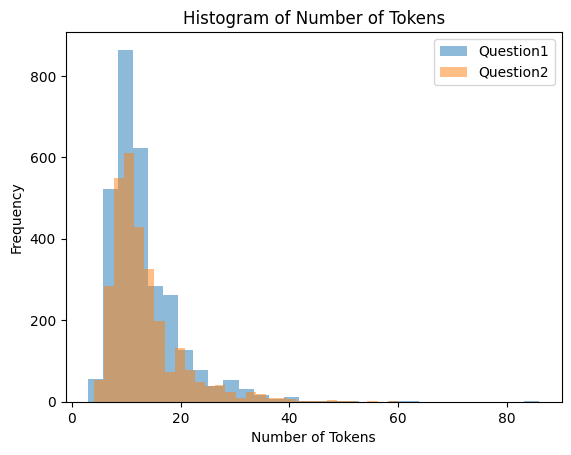

In [ ]:
max_tokens_q1 = 0
token_counts_q1 = []

for question1 in df['question1']:
    tokens = tokenizer.tokenize(question1)
    token_count = len(tokens)
    max_tokens_q1 = max(max_tokens_q1, token_count)
    token_counts_q1.append(token_count)

print("Maximum number of tokens in question1s:", max_tokens_q1)

max_tokens_q2 = 0
token_counts_q2 = []

for question2 in df['question2']:
    tokens = tokenizer.tokenize(question2)
    token_count = len(tokens)
    max_tokens_q2 = max(max_tokens_q2, token_count)
    token_counts_q2.append(token_count)

print("Maximum number of tokens in question2s:", max_tokens_q2)

plt.hist(token_counts_q1, bins=30, alpha=0.5, label='Question1')
plt.hist(token_counts_q2, bins=30, alpha=0.5, label='Question2')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Tokens')
plt.legend()
plt.show()

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=2)

In [ ]:
def batchTokenize(sample):
    return tokenizer(sample["question1"], sample["question2"],  padding='max_length', truncation=True, max_length = max_tokens_q1 + max_tokens_q2 + 10)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(batchTokenize, batched=True)
test_dataset = test_dataset.map(batchTokenize, batched=True)


Map:   0%|          | 0/2686 [00:00<?, ? examples/s]

Map:   0%|          | 0/299 [00:00<?, ? examples/s]

In [ ]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [ ]:
model_copy = copy.deepcopy(model)

In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
trainable_params1 = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in initial model:", trainable_params1)

Number of trainable parameters in initial model: 355361794


In [ ]:
trainer_args = TrainingArguments(
    output_dir                  = "./result1",
    overwrite_output_dir        = True,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    gradient_accumulation_steps = 1,
    learning_rate               = 1e-06,
    adam_epsilon                = 1e-08,
    logging_steps               = 100,
    num_train_epochs            = 10.0,
    save_strategy               = "epoch",
    evaluation_strategy         = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "accuracy",
    report_to = 'wandb',
    )

def compute_metrics(eval_pred):
    metric = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model                       = model,
    args                        = trainer_args,
    train_dataset               = train_dataset,
    eval_dataset                = test_dataset,
    compute_metrics             = compute_metrics,
    )

In [ ]:
%%wandb
trainer.train()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: fateme-jlilii (fatemeh_nndl). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.697100,0.663496,0.632107
2,0.622700,0.568707,0.725753
3,0.581300,0.554128,0.715719
4,0.559900,0.524771,0.759197
5,0.534700,0.500775,0.775920
6,0.505900,0.469979,0.789298
7,0.492600,0.447043,0.812709
8,0.485100,0.435029,0.816054
9,0.467600,0.427066,0.819398


<ipython-input-22-92ca1ba67c29>:19: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

Epoch,Training Loss,Validation Loss,Accuracy
1,0.697100,0.663496,0.632107
2,0.622700,0.568707,0.725753
3,0.581300,0.554128,0.715719
4,0.559900,0.524771,0.759197
5,0.534700,0.500775,0.775920
6,0.505900,0.469979,0.789298
7,0.492600,0.447043,0.812709
8,0.485100,0.435029,0.816054
9,0.467600,0.427066,0.819398
10,0.455700,0.428638,0.819398


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.427066445350647,
 'eval_accuracy': 0.8193979933110368,
 'eval_runtime': 7.7629,
 'eval_samples_per_second': 38.517,
 'eval_steps_per_second': 2.448,
 'epoch': 10.0}

In [ ]:
prediction = trainer.predict(test_dataset)
predictions = prediction.predictions.argmax(-1)
print(classification_report(prediction.label_ids, predictions, labels=[0, 1]))

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.89      0.75      0.81       157
           1       0.76      0.90      0.83       142

    accuracy                           0.82       299
   macro avg       0.83      0.82      0.82       299
weighted avg       0.83      0.82      0.82       299



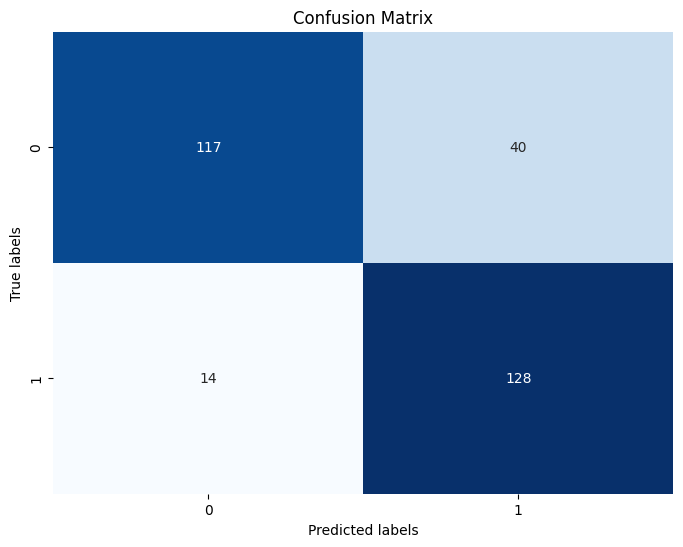

In [ ]:
labels = prediction.label_ids
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["query", "key","value"],
    bias='none',
    task_type=TaskType.SEQ_CLS
)
peft_model = get_peft_model(model_copy, lora_config)

In [ ]:
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 1024, padding_idx=1)
          (position_embeddings): Embedding(514, 1024, padding_idx=1)
          (token_type_embeddings): Embedding(1, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-23): 24 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): 

In [ ]:
trainable_params2 = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
print("Number of trainable parameters in LoRA applied model:", trainable_params2)
print("percentage of trainable model parameters in comparison to initial model:", trainable_params2 * 100 / trainable_params1)

Number of trainable parameters in LoRA applied model: 2231298
percentage of trainable model parameters in comparison to initial model: 0.6278947364836862


In [ ]:
trainer_args = TrainingArguments(
    output_dir                  = "./result2",
    overwrite_output_dir        = True,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    gradient_accumulation_steps = 1,
    learning_rate               = 1e-04,
    adam_epsilon                = 1e-08,
    logging_steps               = 100,
    num_train_epochs            = 10.0,
    save_strategy               = "epoch",
    evaluation_strategy         = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "accuracy",
    report_to = 'wandb',
    )

def compute_metrics(eval_pred):
    metric = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model                       = peft_model,
    args                        = trainer_args,
    train_dataset               = train_dataset,
    eval_dataset                = test_dataset,
    compute_metrics             = compute_metrics,
    )

In [ ]:
wandb.finish()

In [ ]:
%%wandb
trainer.train()

wandb: Currently logged in as: fateme-jlilii (fatemeh_nndl). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.703400,0.627229,0.759197
2,0.563700,0.436011,0.799331
3,0.467200,0.375744,0.819398
4,0.414400,0.376062,0.842809
5,0.373100,0.348590,0.842809
6,0.385500,0.337056,0.862876
7,0.335500,0.376064,0.872910
8,0.335900,0.372193,0.846154
9,0.297600,0.358021,0.856187
10,0.280300,0.350857,0.879599


<ipython-input-26-3e50b11c10cb>:19: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the r

In [ ]:
trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.350856751203537,
 'eval_accuracy': 0.8795986622073578,
 'eval_runtime': 8.5114,
 'eval_samples_per_second': 35.129,
 'eval_steps_per_second': 2.232,
 'epoch': 10.0}

In [ ]:
prediction = trainer.predict(test_dataset)
predictions = prediction.predictions.argmax(-1)
print(classification_report(prediction.label_ids, predictions, labels=[0, 1]))

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.89      0.85      0.87       144
           1       0.87      0.90      0.89       155

    accuracy                           0.88       299
   macro avg       0.88      0.88      0.88       299
weighted avg       0.88      0.88      0.88       299



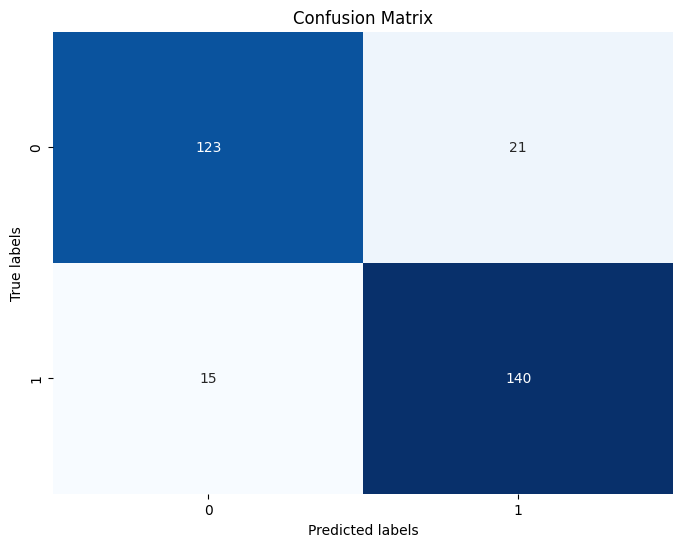

In [ ]:
labels = prediction.label_ids
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()